In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
from ta import momentum, trend
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dxy = yf.download("DX-Y.NYB", start="2015-01-01", end="2020-12-31")['Close']
dxy_shifted = dxy.shift(1)
dxy['log_returns'] = np.log(dxy / dxy_shifted)
dxy['ret_means'] = dxy['log_returns'].rolling(5).mean()
dxy['volatility'] = dxy['log_returns'].rolling(5).std()
dxy = dxy[::-1].dropna()
dxy

In [ ]:
mu = dxy['ret_means'].mean()
sigma = dxy['ret_means'].std()
range_factor = 1
lb = mu - range_factor * sigma
ub = mu + range_factor * sigma
vol_bound = dxy['volatility'].quantile(0.7)

sns.histplot(dxy['ret_means'], bins=100, kde=True)
plt.vlines(x=[lb, ub], ymin=0, ymax=100)

In [ ]:
conditions = [
    (dxy['ret_means'] >= ub) & (dxy['volatility'] < vol_bound),
    (dxy['ret_means'] >= ub) & (dxy['volatility'] >= vol_bound),
    (dxy['ret_means'] <= lb) & (dxy['volatility'] < vol_bound),
    (dxy['ret_means'] <= lb) & (dxy['volatility'] >= vol_bound),
]
dxy['regime'] = np.select(conditions, [1, 2, -1, -2], default=0)
dxy

In [ ]:
sns.lineplot(dxy['log_returns'])
sns.lineplot(dxy['ret_means'])

In [ ]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv', delimiter=',', index_col='Date')
df_shifted = df.shift(1)
df['log_returns'] = np.log(df / df_shifted)
df['ret_means'] = df['log_returns'].rolling(5).mean()
df['volatility'] = df['log_returns'].rolling(5).std()
df['SMA_crossover'] = df['log_returns'].rolling(20).mean() - df['log_returns'].rolling(50).mean()
df = df[::-1].dropna()
df

In [ ]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv', delimiter=',', index_col='Date')
df['MACD'] = df['EURUSD=X'].ewm(span=12, adjust=False).mean() - df['EURUSD=X'].ewm(span=26, adjust=False).mean()
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_val'] = df['MACD'] - df['MACD_signal']
df = df[::-1]
df

In [ ]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv', delimiter=',', index_col='Date')
df = df[::-1]
df['RSI'] = momentum.rsi(df['EURUSD=X'], window=14)
df['MACD'] = trend.macd(df['EURUSD=X'])
df.dropna(inplace=True)
df

In [ ]:
import os

In [ ]:
dataframes = {}

for file in os.listdir('../../data/processed/currency'):
    ticker = file.split('.csv')[0]
    curr_df = pd.read_csv(f'../../data/processed/currency/{file}', delimiter=',', index_col='Date')
    dataframes[ticker] = curr_df
dataframes

In [ ]:
# Step 1: concatenate all DataFrames along columns
big_df = pd.concat(dataframes, axis=1)  # MultiIndex columns (currency, indicator)

# Step 2: drop rows (dates) with any missing value
big_df = big_df.dropna()

# Step 3: build a per-date dictionary of DataFrames
per_date_dfs = {
    date: big_df.loc[date].unstack()  # unstack turns MultiIndex into rows=indicators, cols=currencies
    for date in big_df.index
}
per_date_dfs['2020-03-27']

In [ ]:
df = per_date_dfs['2020-03-27']
# Plot heatmap
# Normalize each column separately (min-max scaling per column)
df_norm = df.copy()
for col in df.columns:
    col_mean = df[col].mean()
    col_std = df[col].std()
    df_norm[col] = (df[col] - col_mean) / col_std

# Plot heatmap with normalized values
# Plot clean heatmap
plt.axis("off")  # remove axes
plt.imshow(df_norm.values, cmap="magma", aspect="auto")
plt.savefig("heatmap.png", bbox_inches="tight", pad_inches=0, dpi=1080)  # no whitespace
# plt.show()

In [ ]:
plt.axis("off")
sns.heatmap(df_norm, cmap="magma", annot=False, cbar=False)

In [ ]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv')
df

In [ ]:
def qv(window):
    diffs = np.diff(window)
    return sum(diffs ** 2)


df['QV'] = df['EURUSD=X'].rolling(3).apply(lambda x: sum(np.diff(x) ** 2), raw=True)
df

In [ ]:
dxy = yf.download("DX-Y.NYB", start="2018-01-01", end="2020-12-31")['Close']
sns.lineplot(dxy)

In [ ]:
tickers = 'EURUSD=X,GBPUSD=X,AUDUSD=X,NZDUSD=X'.split(',')
for ticker in tickers:
    df = yf.download(ticker, start="2018-01-01", end="2020-12-31")['Close']
    df = 1 / df
    sns.lineplot(df)
    plt.show()

In [13]:
scaler = MinMaxScaler()
dxy = yf.download('USDGBP=X', start="2020-01-01", end="2020-12-31")[['Close', 'High', 'Low']]
dxy.columns = ['Close', 'High', 'Low']
dxy['scaledClose'] = scaler.fit_transform(dxy['Close'].to_numpy().reshape(-1, 1))
# RET Feature
dxy['SMA'] = dxy['Close'].rolling(10).mean()
dxy['SMA_log_ret'] = np.log(dxy['SMA'] / dxy['SMA'].shift())
dxy['SMA_log_ret_mean'] = dxy['SMA_log_ret'].rolling(5).mean()
past_mean = dxy['SMA_log_ret_mean'].expanding().mean().shift(1)
dxy['RET_Feature'] = np.where(dxy['SMA_log_ret_mean'] > past_mean, 1, 0)
# Aroon Feature
dxy['AroonUp'] = trend.aroon_up(dxy['High'], dxy['Low'], window=10)
dxy['AroonDown'] = trend.aroon_down(dxy['High'], dxy['Low'], window=10)
dxy['Aroon'] = dxy['AroonUp'] - dxy['AroonDown']
dxy['AROON_Feature'] = np.where(dxy['Aroon'] > 30, 1, 0)
# MACD Feature
dxy['MACD'] = -trend.macd(dxy['Close'], window_slow=10, window_fast=11)
dxy['MACD_Feature'] = np.where(np.sign(dxy['MACD']) > 0, 1, 0)
# QV Feature
dxy['QV'] = dxy['Close'].rolling(5).apply(lambda x: sum(np.diff(x) ** 2), raw=True)
dxy['scaledQV'] = scaler.fit_transform(dxy['QV'].to_numpy().reshape(-1,1))
past_mean = dxy['QV'].expanding().mean().shift(1)
dxy['QV_Feature'] = np.where(dxy['QV'] > past_mean, 1, 0)

dxy.drop(columns=['Close', 'High', 'Low', 'SMA', 'SMA_log_ret', 'SMA_log_ret_mean', 'AroonUp', 'AroonDown', 'Aroon',
                  'MACD'],
         inplace=True, axis=1)
dxy['regime'] = np.where(dxy['AROON_Feature'] + dxy['MACD_Feature'] + dxy['RET_Feature'] > 1, 1, 0)
dxy

[*********************100%***********************]  1 of 1 completed


,scaledClose,RET_Feature,AROON_Feature,MACD_Feature,QV,scaledQV,QV_Feature,regime
Date,,,,,,,,
2020-01-01,0.129204,0,0,0,NaN,NaN,0,0
2020-01-02,0.134459,0,0,0,NaN,NaN,0,0
2020-01-03,0.176501,0,0,0,NaN,NaN,0,0
2020-01-06,0.208183,0,0,0,NaN,NaN,0,0
2020-01-07,0.168994,0,0,0,0.000077,0.047317,0,0
...,...,...,...,...,...,...,...,...
2020-12-24,0.027478,0,0,0,0.000134,0.085020,1,0
2020-12-25,0.008318,0,0,0,0.000055,0.033254,0,0
2020-12-28,0.000000,0,0,0,0.000050,0.029494,0,0


<Axes: xlabel='Date', ylabel='scaledClose'>

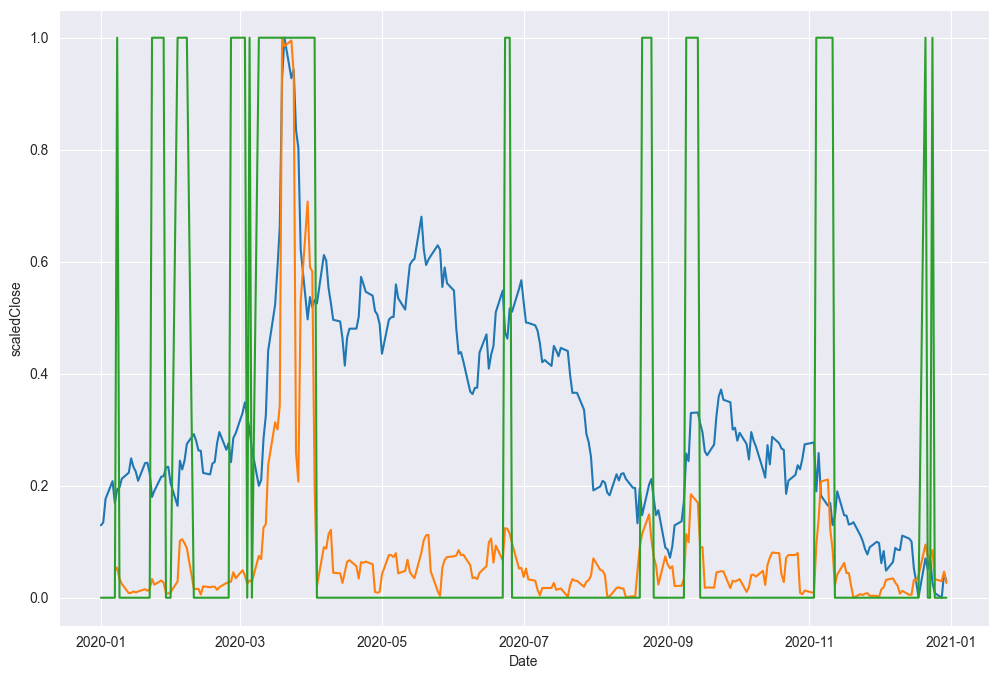

In [14]:
plt.figure(figsize=(12, 8))
sns.lineplot(dxy['scaledClose'])
# sns.lineplot(dxy['RET_Feature'])
# sns.lineplot(dxy['MACD_Feature'])
# sns.lineplot(dxy['AROON_Feature'])
sns.lineplot(dxy['scaledQV'])
sns.lineplot(dxy['QV_Feature'])

In [26]:
df = pd.read_csv('../../data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.drop('Date', inplace=True, axis=1)
df

,scaledClose,RET_Feature
Date,,
2015-01-02,0.169388,0
2015-01-05,0.189796,0
2015-01-06,0.197959,0
2015-01-07,0.224490,0
2015-01-08,0.257143,0
...,...,...
2019-12-24,0.616327,0
2019-12-26,0.612245,1
2019-12-27,0.566667,1


<Axes: xlabel='Date'>

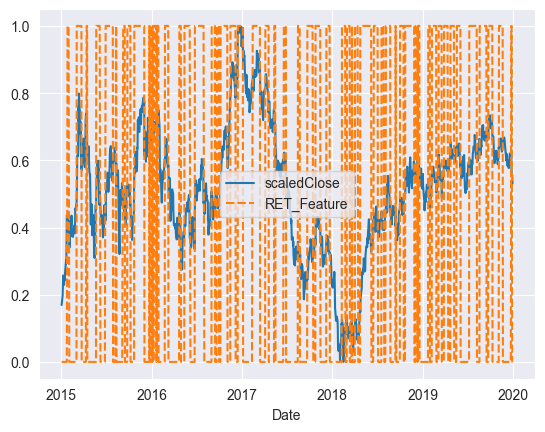

In [27]:
sns.lineplot(df)

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

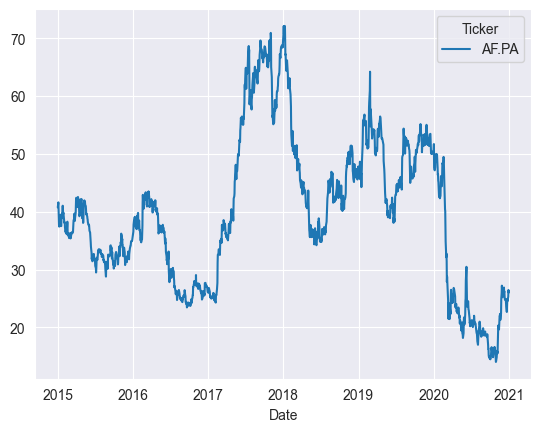

In [15]:
data = yf.download('AF.PA', start='2015-01-01', end='2020-12-31')['Close']
sns.lineplot(data)

In [16]:
data

Ticker,AF.PA
Date,
2015-01-02,40.756340
2015-01-05,41.613731
2015-01-06,40.130947
2015-01-07,38.975990
2015-01-08,37.735298
...,...
2020-12-23,24.864344
2020-12-24,24.526430
2020-12-28,25.298082
